# Sentiment Analysis on mobile phone reviews

The given task is to learn sentiment from all the given reviews and predict rating from a new review. This objective is attained by following the steps listed below:

### Importing the modules

In [2]:
import pandas as pd
import numpy as np
import nltk
import future
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 

### Data Labeling

- In this step we clean the data and label the data as <br>
  > 0 for Poor <br>
  > 1 for Neutral <br>
  > 2 for Good
- Read the data from __'Amazon_Unlocked_Mobile.csv'__ and add new column for labels

In [3]:
def label_data():
    rows = pd.read_csv('/home/nanu/Desktop/sagar/Amazon_Unlocked_Mobile.csv', header=0, index_col=False, delimiter=',')
    labels = []
    for cell in rows['Rating']:
        if cell >= 4:
            labels.append('2')   #Good
        elif cell == 3:
            labels.append('1')   #Neutral
        else:
            labels.append('0')   #Poor
            
    rows['Label'] = labels
    del rows['Review Votes']
    return rows

### Data Cleaning

Remove all the rows containing blank cells. The resultant data is stored as __'labelled_dataset.csv'__

In [4]:
def clean_data(data):
    #columnwise print number of rows containing blank values
    #print data.isnull().sum()
    
    #replace blank values in all the cells with 'nan'
    data.replace('',np.nan,inplace=True)
    #delete all the rows which contain at least one cell with nan value
    data.dropna(axis=0, how='any', inplace=True)
    
    #Check the number of rows containing blank values. This should be zero now as compared to first line of this function
    #print data.isnull().sum()
    #save output csv file
    data.to_csv('labelled_dataset.csv', index=False)
    return data

### Data preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.

- remove html tags using BeautifulSoup
- remove non-character such as digits and symbols
- convert to lower case
- remove stop words such as "the" and "and" if needed
- convert to root words by stemming if needed

In [5]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [6]:
def modelEvaluation(predictions, y_test_set):
    #Print model evaluation to predicted result 
    
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))
    #print "\nAUC score : {:.4f}".format(roc_auc_score(y_test_set, predictions))
    print ("\nClassification report : \n", metrics.classification_report(y_test_set, predictions))
    print ("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test_set, predictions))

### Bag of Words

The sentiment analysis of given text can be done in two ways. First, we need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's the workflow in this part.

- Step 1 : Preprocess raw reviews to cleaned reviews
- Step 2 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
- Step 3 : Transform review text to numerical representations (feature vectors)
- Step 4 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
- Step 5 : Improve the model performance by GridSearch

In [7]:
if __name__ == '__main__':
    data = label_data()
    data = clean_data(data)
    #prints first 5 rows of the dataset
    print (data.head())    

                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews Label  
0       5  I feel so LUCKY to have found this used (phone...     2  
1       4  nice phone, nice up grade from my pantach revu...     2  
2       5                                       Very pleased     2  
3       4  It works good but it goes slow sometimes but i...     2  
4       4  Great phone to replace my lost phone. The only...     2  


### Visualisation

Text(0, 0.5, 'Count')

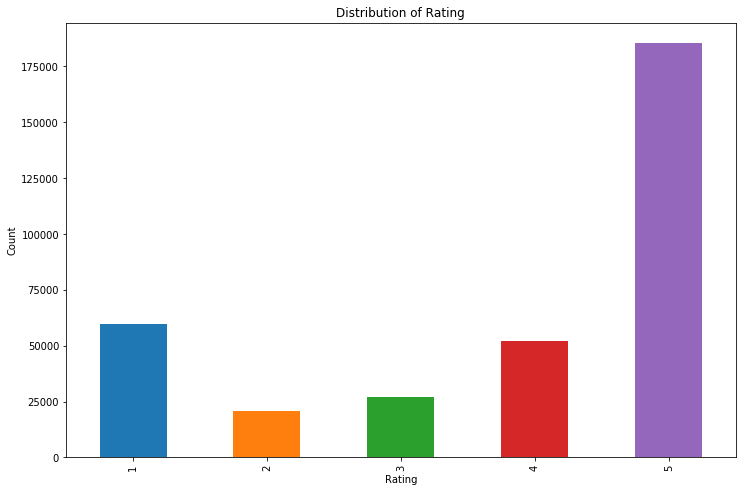

In [8]:
    # Plot distribution of rating
    plt.figure(figsize=(12,8))
    # sns.countplot(data['Rating'])
    data['Rating'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Rating')
    plt.xlabel('Rating')
    plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

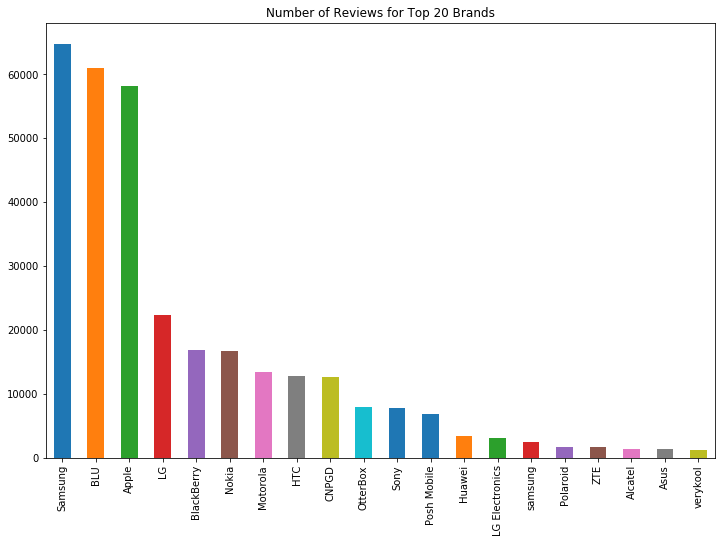

In [9]:
    # Plot number of reviews for top 20 brands
    brands = data["Brand Name"].value_counts()
    # brands.count()
    plt.figure(figsize=(12,8))
    brands[:20].plot(kind='bar')
    plt.title("Number of Reviews for Top 20 Brands")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

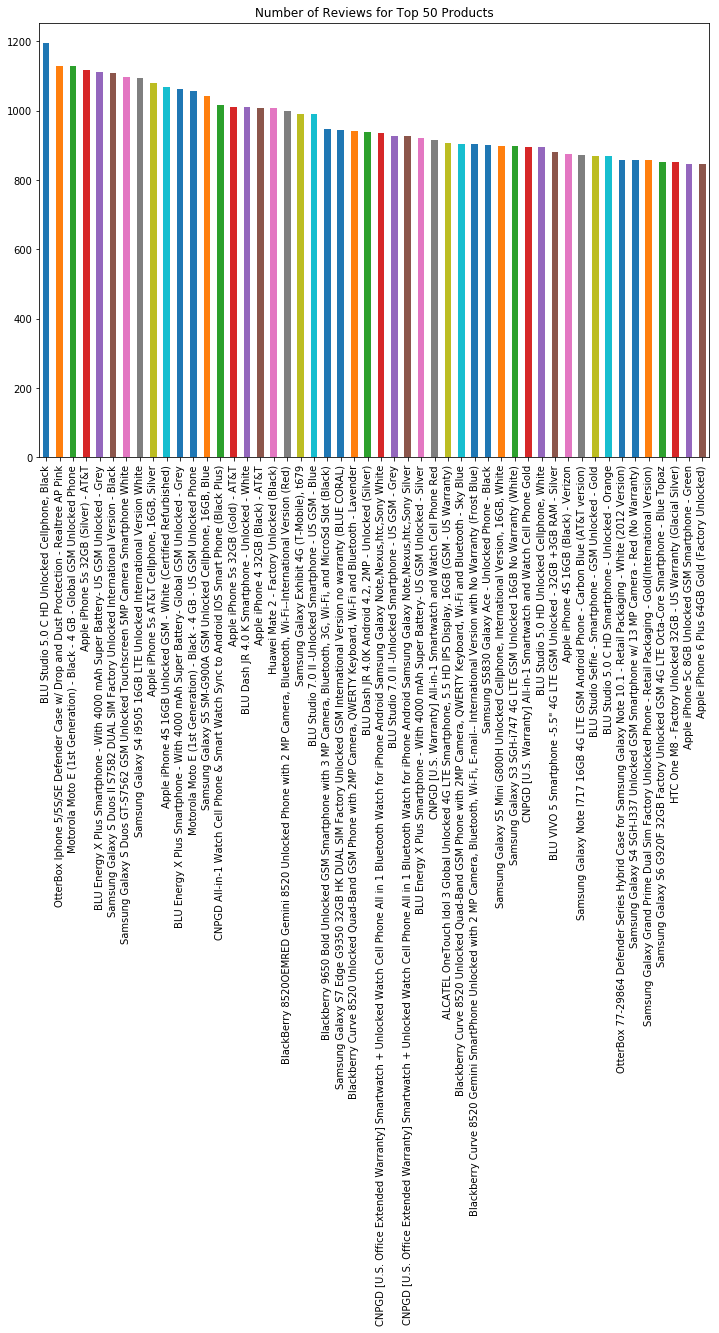

In [10]:
    # Plot number of reviews for top 50 products
    products = data["Product Name"].value_counts()
    plt.figure(figsize=(12,8))
    products[:50].plot(kind='bar')
    plt.title("Number of Reviews for Top 50 Products")

Text(0, 0.5, 'Count')

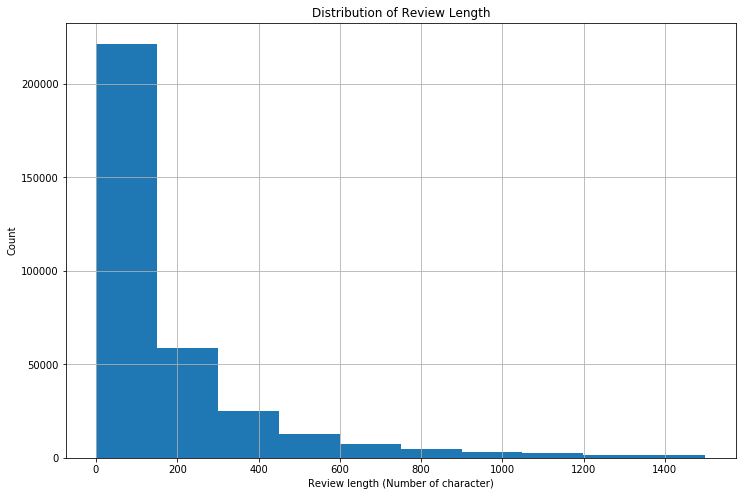

In [11]:
    # Plot distribution of review length
    review_length = data["Reviews"].dropna().map(lambda x: len(x))
    plt.figure(figsize=(12,8))
    review_length.loc[review_length < 1500].hist()
    plt.title("Distribution of Review Length")
    plt.xlabel('Review length (Number of character)')
    plt.ylabel('Count')

In [12]:
    #split data into training and testing set
    x_train, x_test, y_train, y_test = train_test_split(data['Reviews'], data['Label'], test_size=0.1, random_state=0)
    
    
    #If the label are words instead of numbers, they can be replaced programmatically using following two lines
    #y_train = label_binarize(y_train, classes=[0, 1, 2])
    #y_test = label_binarize(y_test, classes=[0, 1, 2])

In [13]:
    # Preprocess text data in training set and validation set
    x_train_cleaned = []
    x_test_cleaned = []

    for d in x_train:
        x_train_cleaned.append(cleanText(d))

    for d in x_test:
        x_test_cleaned.append(cleanText(d))    

/home/nanu/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/B00OSTKZWM?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_1" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/nanu/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/nanu/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "https://www.amazon.com/gp/product/B00U8KSNB0/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a 

### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm.

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.

In [14]:
    # Fit and transform the training data to a document-term matrix using CountVectorizer
    countVect = CountVectorizer() 
    x_train_countVect = countVect.fit_transform(x_train_cleaned)
    print ("Number of features : %d \n" %len(countVect.get_feature_names()) )#6378 
    print ("Show some feature names : \n", countVect.get_feature_names()[::1000])

Number of features : 54166 

Show some feature names : 
 ['aa', 'aerial', 'andcamera', 'ascetics', 'baggies', 'birdwatching', 'broadcasters', 'cannoy', 'cherished', 'commend', 'consumo', 'crunched', 'deficient', 'diffcult', 'dong', 'electing', 'esper', 'expirience', 'finecamera', 'friendlier', 'girls', 'guessedit', 'hhi', 'ilemming', 'instagraming', 'iwhatever', 'lablel', 'literallyhave', 'maneuverable', 'microsost', 'movillnet', 'nicelooking', 'office', 'outreach', 'percentbecause', 'pla', 'prepain', 'providing', 'raving', 'regale', 'restoration', 'salgan', 'semipro', 'simscroll', 'solidarity', 'starr', 'superglue', 'telefonical', 'tidy', 'tricks', 'uninstallation', 'vampire', 'wapencmms', 'withxxex', 'yupp']


In [15]:
    # Train MultinomialNB classifier
    mnb = MultinomialNB()
    mnb.fit(x_train_countVect, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [16]:
    # Evaluate the model on validaton set
    predictions = mnb.predict(countVect.transform(x_test_cleaned))
    modelEvaluation(predictions, y_test)


Accuracy on validation set: 0.8552

Classification report : 
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      8138
           1       0.45      0.26      0.33      2736
           2       0.90      0.94      0.92     23577

   micro avg       0.86      0.86      0.86     34451
   macro avg       0.72      0.67      0.69     34451
weighted avg       0.84      0.86      0.85     34451


Confusion Matrix : 
 [[ 6594   370  1174]
 [  770   724  1242]
 [  923   508 22146]]


### TfidfVectorizer with Logistic Regression

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus.

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [17]:
    # Fit and transform the training data to a document-term matrix using TfidfVectorizer 
    tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
    x_train_tfidf = tfidf.fit_transform(x_train)
    print ("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
    print ("Show some feature names : \n", tfidf.get_feature_names()[::1000])

    # Logistic Regression
    lr = LogisticRegression()
    lr.fit(x_train_tfidf, y_train)

Number of features : 21131 

Show some feature names : 
 ['00', '9100', 'appearence', 'blinding', 'choked', 'cracked', 'directo', 'eq', 'floored', 'guidebook', 'indiscernible', 'leads', 'miami', 'occupied', 'pig', 'quedo', 'reviewedblackberry', 'shutting', 'studies', 'tmob', 'varies', 'youll']


/home/nanu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nanu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
    # Look at the top 10 features with smallest and the largest coefficients
    feature_names = np.array(tfidf.get_feature_names())
    sorted_coef_index = lr.coef_[0].argsort()
    print ("Total number of features = " + str(len(sorted_coef_index)))
    print ('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
    print ('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Total number of features = 21131

Top 10 features with smallest coefficients :
['love' 'great' 'excellent' 'amazing' 'perfect' 'loves' 'perfectly' 'best'
 'awesome' 'easy']

Top 10 features with largest coefficients : 
['not' 'worst' 'waste' 'junk' 'useless' 'unusable' 'horrible' 'terrible'
 'garbage' 'disappointed']


In [19]:
    # Evaluate on the validaton set
    predictions = lr.predict(tfidf.transform(x_test_cleaned))
    modelEvaluation(predictions, y_test)


Accuracy on validation set: 0.8812

Classification report : 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      8138
           1       0.65      0.16      0.26      2736
           2       0.91      0.97      0.94     23577

   micro avg       0.88      0.88      0.88     34451
   macro avg       0.79      0.67      0.68     34451
weighted avg       0.87      0.88      0.86     34451


Confusion Matrix : 
 [[ 7122   104   912]
 [  896   448  1392]
 [  651   137 22789]]


### SVM and Trees

system will use two algorithms SVM and Random Forest to perform analysis and to determine which suits better for recommendation.

### Support Vector Machine

Here we implement multi-svm for sentiment analysis. More information about it can be found on [this](http://scikit-learn.org/stable/modules/svm.html) link. <br>

- Tip 1 : Here, different kernels can be tried out. For example, linear, nonlinear, precomputed, rbf etc.
- Tip 2 : The parameter values given below can be tweaked to obtain different results.

### Using LinearSVC

Here you can tweak the api parameters of LinearSVC as per your choice. Refer to [this](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) link for making any changes.

In [20]:
    #x_train_subset = tfidf.transform(x_train_cleaned[:100])
    x_train_input = tfidf.transform(x_train_cleaned)
    svr_lin = LinearSVC(multi_class='ovr',C=1.0,loss='squared_hinge', dual=False)
    svr_lin.fit(x_train_input, y_train)
    y_svr_lin_predicted = svr_lin.predict(tfidf.transform(x_test_cleaned))

In [21]:
    modelEvaluation(y_svr_lin_predicted, y_test)


Accuracy on validation set: 0.8916

Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8138
           1       0.74      0.25      0.37      2736
           2       0.92      0.97      0.94     23577

   micro avg       0.89      0.89      0.89     34451
   macro avg       0.83      0.70      0.72     34451
weighted avg       0.88      0.89      0.88     34451


Confusion Matrix : 
 [[ 7218   112   808]
 [  850   674  1212]
 [  621   130 22826]]


### Functions for Model Evaluation

There are multiple functions for model evaluation in scikit learn. To know more about them, please follow the below mentioned links
- [accuracy score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
- [f_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)
- [f1_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)
- [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

In [22]:
    print ("Accuracy of this SVM = " + str(metrics.accuracy_score(y_test, y_svr_lin_predicted)))
    print ("Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_svr_lin_predicted, pos_label=2, average='weighted')))
    print ("F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_svr_lin_predicted, pos_label=2, average='weighted')))
    print ("confusion matrix = " + str(metrics.confusion_matrix(y_test, y_svr_lin_predicted)))

Accuracy of this SVM = 0.8916432033903224
Fscore of this SVM = (0.883388648009047, 0.8916432033903224, 0.8771689786210045, None)


/home/nanu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1052: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


F-1 score of this SVM = 0.8771689786210045
confusion matrix = [[ 7218   112   808]
 [  850   674  1212]
 [  621   130 22826]]


### Random Forest

Refer to [this](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#id1) link for more information

In [23]:
    rand = RandomForestClassifier()
    rand.fit(x_train_input, y_train)
    y_rand_predicted = rand.predict(tfidf.transform(x_test_cleaned))

/home/nanu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [24]:
    modelEvaluation(y_rand_predicted, y_test)


Accuracy on validation set: 0.9407

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      8138
           1       0.97      0.65      0.78      2736
           2       0.95      0.98      0.96     23577

   micro avg       0.94      0.94      0.94     34451
   macro avg       0.94      0.85      0.89     34451
weighted avg       0.94      0.94      0.94     34451


Confusion Matrix : 
 [[ 7493    31   614]
 [  321  1771   644]
 [  405    29 23143]]


In [25]:
    print ("Accuracy of Random Forest = " + str(rand.score(tfidf.transform(x_test_cleaned), y_test)))
    print ("Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_rand_predicted, pos_label=2, average='weighted')))
    print ("F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_rand_predicted, pos_label=2, average='weighted')))
    print ("confusion matrix = " + str(metrics.confusion_matrix(y_test, y_rand_predicted)))

Accuracy of Random Forest = 0.9406693564773156
Fscore of this SVM = (0.9412493250396435, 0.9406693564773156, 0.938241760559969, None)
F-1 score of this SVM = 0.938241760559969
confusion matrix = [[ 7493    31   614]
 [  321  1771   644]
 [  405    29 23143]]


/home/nanu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1052: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


### Decision Tree

Refer [this](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) link for more information

In [26]:
    decTree = DecisionTreeClassifier()
    decTree.fit(x_train_input, y_train)
    y_decTree_predicted = decTree.predict(tfidf.transform(x_test_cleaned))

In [27]:
    modelEvaluation(y_decTree_predicted, y_test)


Accuracy on validation set: 0.9272

Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      8138
           1       0.79      0.70      0.74      2736
           2       0.95      0.96      0.96     23577

   micro avg       0.93      0.93      0.93     34451
   macro avg       0.88      0.85      0.86     34451
weighted avg       0.93      0.93      0.93     34451


Confusion Matrix : 
 [[ 7286   229   623]
 [  299  1909   528]
 [  536   293 22748]]


In [28]:
    print ("Accuracy of Decision Tree = " + str(decTree.score(tfidf.transform(x_test_cleaned), y_test)))
    print ("Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_decTree_predicted, pos_label=2, average='weighted')))
    print ("F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_decTree_predicted, pos_label=2, average='weighted')))
    print ("confusion matrix =\n " + str(metrics.confusion_matrix(y_test, y_decTree_predicted)))

Accuracy of Decision Tree = 0.9272009520768628
Fscore of this SVM = (0.9256993509858683, 0.9272009520768628, 0.9262145632587147, None)
F-1 score of this SVM = 0.9262145632587147
confusion matrix =
 [[ 7286   229   623]
 [  299  1909   528]
 [  536   293 22748]]


/home/nanu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1052: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [29]:
data.loc[data.Rating>3,'Sentiment']="POSITIVE"
data.loc[data.Rating<=3,'Sentiment']="NEGATIVE"

In [30]:
reviews = data.Reviews.values
labels = data.Sentiment.values

In [31]:
def pretty_print_review_and_label(i):
    if data.Sentiment[i]=="POSITIVE":
        print("POSITIVE" + "\t" + reviews[i][:90] + "...")
    else:
        print("NEGATIVE" + "\t " + reviews[i][:90] + "...")
    

In [32]:
pretty_print_review_and_label(1)
pretty_print_review_and_label(4)
pretty_print_review_and_label(5)
pretty_print_review_and_label(50)


POSITIVE	nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. never ...
POSITIVE	Great phone to replace my lost phone. The only thing is the volume up button does not work...
NEGATIVE	 I already had a phone with problems... I know it stated it was used, but dang, it did not ...
POSITIVE	Shipped quickly and was exactly what I expected!...


In [33]:
positive_reviews = [reviews[i] for i in range(len(reviews)) if labels[i]=="POSITIVE"]
negative_reviews = [reviews[i] for i in range(len(reviews)) if labels[i]=="NEGATIVE"]

In [34]:
from collections import Counter

cnt_positve = Counter()

for row in positive_reviews:
    cnt_positve.update(row.split(" "))
print("Vocabulary size for positve reviews:", len(cnt_positve.keys()))

cnt_negative = Counter()

for row in negative_reviews:
    cnt_negative.update(row.split(" "))
print("Vocabulary size for positve reviews:", len(cnt_negative.keys()))

cnt_total = Counter()

for row in reviews:
    cnt_total.update(row.split(" "))

Vocabulary size for positve reviews: 161598
Vocabulary size for positve reviews: 117189


In [35]:
pos_neg_ratio = Counter()
vocab_pos_neg = (set(cnt_positve.keys())).intersection(set(cnt_negative.keys()))
for word in vocab_pos_neg:
    if cnt_total[word]>100:
        ratio = cnt_positve[word]/float(cnt_negative[word]+1)
        if ratio>1:
            pos_neg_ratio[word] = np.log(ratio)
        else:
            pos_neg_ratio[word] = -np.log(1/(ratio+0.01)) 

In [36]:
pos_neg_ratio .most_common()[:30]

[('Excelent', 4.876468779189348),
 ('Excelente', 4.801148069229532),
 ('excelente', 4.681811891339931),
 ('Excellent,', 4.618415412738112),
 ('Perfect!', 4.524502282920636),
 ('EXCELENTE', 4.44461012097565),
 ('perfecto', 4.430816798843313),
 ('excelent', 4.429114670772783),
 ('exelente', 4.39268392914787),
 ('EXCELENT', 4.31748811353631),
 ('exceeds', 4.30406509320417),
 ('Perfect', 4.262252982691183),
 ('Excellent', 4.1151664631424785),
 ('recomendado', 4.0943445622221),
 ('far!', 4.046553898385752),
 (':D', 4.029806041084529),
 ('Perfectly', 3.960813169597578),
 ('👍', 3.9512437185814275),
 ('perfect!', 3.784189633918261),
 ('Outstanding', 3.7455747977904816),
 ('Awesome!', 3.7436043538031827),
 ('EXCELLENT', 3.709812663780402),
 ('Amazing', 3.669154948766158),
 ('unbiased', 3.6463198396951406),
 ('perfectamente', 3.628775530044231),
 ('fantastic!', 3.592735593561034),
 ('Awesome', 3.5767621559932303),
 ('Met', 3.5600986642480112),
 ('Exelent', 3.545778610473263),
 ('packs', 3.516508

/home/nanu/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


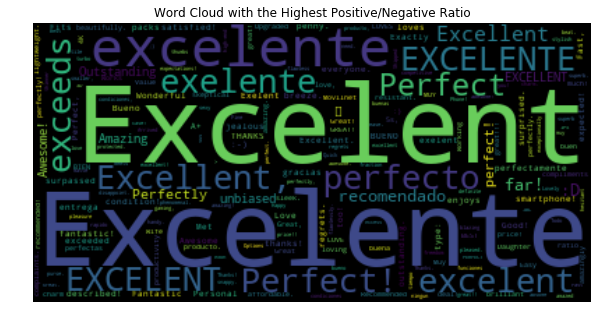

In [37]:
from wordcloud import WordCloud
positive_dict = {}
for word, cnt in pos_neg_ratio.items():
    if (cnt>1):
        positive_dict[word] = cnt

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=positive_dict)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
ax = plt.axes()
ax.set_title('Word Cloud with the Highest Positive/Negative Ratio')
plt.show()

In [38]:
list(reversed(pos_neg_ratio.most_common()))[0:30]


[('Waste', -3.7548130497923045),
 ('Terrible', -3.5729723402189886),
 ('unsatisfied', -3.545024178147778),
 ('Horrible', -3.1147064945805276),
 ('Returning', -3.0568199655338293),
 ('Stopped', -2.908555893676436),
 ('cheated', -2.86259362820165),
 ('FAKE', -2.805028438007232),
 ('Piece', -2.7577377143337944),
 ('Constantly', -2.6762095952465517),
 ('screws', -2.5890844331967773),
 ('Buyer', -2.564136290960519),
 ('RMA', -2.5218300038925983),
 ('sucks!', -2.5158221241054637),
 ('unusable.', -2.459569974057179),
 ('repairs', -2.4289990178497045),
 ('motherboard', -2.425528479209739),
 ('refund,', -2.407945608651872),
 ('Worst', -2.401997635725795),
 ('freezes,', -2.3863231446387063),
 ('dissatisfied', -2.3829443064464546),
 ('trash.', -2.3647853830047896),
 ('Unable', -2.354871929440474),
 ('junk.', -2.327312268393686),
 ('faulty.', -2.31153592351413),
 ('Returned', -2.2759220364163757),
 ('worse,', -2.2563043404300394),
 ('refund.', -2.2373674546826656),
 ('waste', -2.2298662354101624),

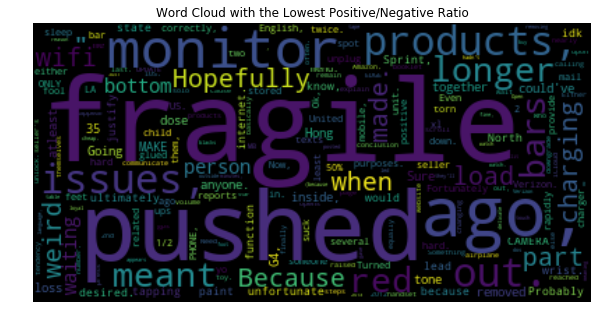

In [39]:
negative_dict = {}
for word, cnt in pos_neg_ratio.items():
    if (cnt<1) & (cnt>0):
        negative_dict[word] = -np.log(cnt)

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=negative_dict)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
ax = plt.axes()
ax.set_title('Word Cloud with the Lowest Positive/Negative Ratio')
plt.show()

In [40]:
reviews = data.Reviews.values
labels = np.array([1 if s=="POSITIVE" else 0 for s in data.Sentiment.values])

In [41]:
from string import punctuation
reviews_cleaned = []
for i in range(len(reviews)):
    reviews_cleaned.append(''.join([c.lower() for c in reviews[i] if c not in punctuation]))

In [42]:
print("Before: ",reviews[0])
print("")
print("After: ",reviews_cleaned[0])

Before:  I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!

After:  i feel so lucky to have found this used phone to us  not used hard at all phone on line from someone who upgraded and sold this one my son liked his old one that finally fell apart after 25 years and didnt want an upgrade thank you seller we really appreciate it  your honesty re said used phonei recommend this seller very highly  would but from them again


In [43]:
vocabulary = set(' '.join(reviews_cleaned).split())
print("Vocabulary size: ", len(vocabulary))

Vocabulary size:  118243


In [44]:
def vocabulary_reduction(reviews,min_freq=10,polarity_cut_off=0.1):
    
    pos_count = Counter()
    neg_count = Counter()
    tot_count = Counter()

    for i in range(len(reviews)):
        for word in reviews[i].split():
            tot_count[word]+=1
            if labels[i] == 1:
                pos_count[word]+=1
            else:
                neg_count[word]+=1    
    
    #Identify words with frequency greater than min_freq
    vocab_freq = []
    for word in tot_count.keys():
        if tot_count[word]>min_freq:
            vocab_freq.append(word)  
    
    #Use polarity to reduce vocab
    pos_neg_ratio = Counter()
    vocab_pos_neg = (set(pos_count.keys())).intersection(set(neg_count.keys()))
    for word in vocab_pos_neg:
        if tot_count[word]>100:
            ratio = pos_count[word]/float(neg_count[word]+1)
            if ratio>1:
                pos_neg_ratio[word] = np.log(ratio)
            else:
                pos_neg_ratio[word] = -np.log(1/(ratio+0.01)) 
    
    mean_ratio = np.mean(list(pos_neg_ratio.values()))
    
    vocab_polarity = []
    for word in pos_neg_ratio.keys():
        if (pos_neg_ratio[word]<(mean_ratio-polarity_cut_off)) or (pos_neg_ratio[word]>(mean_ratio+polarity_cut_off)):
            vocab_polarity.append(word)
     
    vocab_rm_polarity = set(pos_neg_ratio.keys()).difference(vocab_polarity)
    vocab_reduced = (set(vocab_freq)).difference(set(vocab_rm_polarity))
 
    reviews_cleaned = []
    
    for review in reviews:
        review_temp = [word for word in review.split() if word in vocab_reduced]
        reviews_cleaned.append(' '.join(review_temp))
    
    return reviews_cleaned

In [45]:
reviews_cleaned = vocabulary_reduction(reviews_cleaned,min_freq=0,polarity_cut_off=0)

In [46]:
# Store all the text from each review in a text variable
text = ' '.join(reviews_cleaned)

# List all the vocabulary contained in the reviews
vocabulary = set(text.split(' '))

# Map each word to an integer
vocabulary_to_int = {word:i for i,word in enumerate(vocabulary,0)}

In [47]:
def reviews_to_integers(reviews):
    reviews_to_int = []
    for i in range(len(reviews)):
        to_int = [vocabulary_to_int[word] for word in reviews[i].split()]
        reviews_to_int.append(to_int)
    return reviews_to_int

reviews_to_int = reviews_to_integers(reviews_cleaned)

In [48]:
review_lengths = [len(review) for review in reviews_to_int]
print("Shortest review:", min(review_lengths))
print("Longest revies:",max(review_lengths))

Shortest review: 0
Longest revies: 5084


/home/nanu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

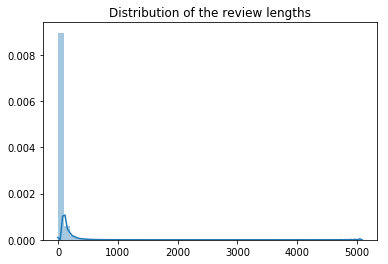

In [49]:
import seaborn as sns
ax = plt.axes()
sns.distplot(review_lengths)
ax.set_title("Distribution of the review lengths")
plt.plot()

In [50]:
pd.DataFrame(review_lengths).describe()

,0
count,344508.000000
mean,40.712857
std,85.361317
min,0.000000
25%,5.000000
50%,18.000000
75%,43.000000
max,5084.000000


In [51]:
max_length = 200
features = np.zeros(shape=(len(reviews_to_int),max_length),dtype=int)

In [52]:
for i in range(len(reviews_to_int)):
    nb_words = len(reviews_to_int[i])
    features[i] = [0]*(max_length -nb_words) + reviews_to_int[i][:200]

In [53]:
from sklearn.model_selection import StratifiedShuffleSplit

In [54]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=5435)

splitter = sss.split(features, labels)
train_index, validation_index = next(splitter)
test_index = validation_index[:int(len(validation_index)/2)]
validation_index = validation_index[int(len(validation_index)/2):]

train_x, train_y = features[train_index], labels[train_index]
val_x, val_y = features[test_index], labels[test_index]
test_x, test_y = features[validation_index], labels[validation_index]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(275606, 200) 
Validation set: 	(34451, 200) 
Test set: 		(34451, 200)


In [55]:
lstm_size = 256
lstm_layers = 1
batch_size = 500
learning_rate = 0.001
embed_size = 200

In [56]:
def build_rnn(vocabulary_to_int,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers):
    
    tf.reset_default_graph()
    
    n_words = len(vocabulary_to_int)
    
    with tf.name_scope('inputs'):
        inputs_ = tf.placeholder(tf.int32,[None, None],name='inputs_')
    with tf.name_scope('labels'):
        labels_ = tf.placeholder(tf.int32,[None, None],name='labels_')
    with tf.name_scope('keep_prob'):    
        keep_prob = tf.placeholder(tf.float32,name='keep_prob')
        
    with tf.name_scope('embedding'):
        embedding = tf.Variable(tf.random_normal((n_words,embed_size),-1,1),name='embedding_')
        embed = tf.nn.embedding_lookup(embedding,inputs_)
        
    with tf.name_scope("RNN_cells"):
        lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)

        # Stack up multiple LSTM layers, for deep learning
        cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layers)
        
        with tf.name_scope("RNN_init_state"):
            # Getting an initial state of all zeros
            initial_state = cell.zero_state(batch_size, tf.float32)
    
    with tf.name_scope("RNN_forward"):
        outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)
        
    with tf.name_scope('predictions'):
        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, 
                                                        activation_fn=tf.sigmoid,
                                                        weights_initializer=
                                                        tf.truncated_normal_initializer(stddev=0.1))   
    with tf.name_scope('cost'):
        cost = tf.losses.mean_squared_error(labels_, predictions)
        tf.summary.scalar('cost', cost)
    
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('accuracy'):
        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    merged = tf.summary.merge_all()
    
    # Export the nodes 
    export_nodes = ['inputs_', 'labels_','initial_state', 'final_state',
                    'keep_prob', 'cell', 'cost', 'predictions', 'optimizer',
                    'accuracy','merged']
    
    Graph = namedtuple('Graph', export_nodes)
    
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In [57]:
import tensorflow as tf
from collections import namedtuple
graph = build_rnn(vocabulary_to_int,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('output/logs/1', sess.graph)

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [58]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [59]:
epochs = 5

def train(model, epoch,train_writer,test_writer):
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        iteration = 1
        for e in range(epochs):
            state = sess.run(model.initial_state)

            for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
                feed = {model.inputs_: x,
                        model.labels_: y[:, None],
                        model.keep_prob: 0.5,
                        model.initial_state: state}
                summary,loss, state, _ = sess.run([model.merged,model.cost, 
                                                   model.final_state, 
                                                   model.optimizer], feed_dict=feed)

                if iteration%5==0:
                    print("Epoch: {}/{}".format(e, epochs),
                          "Iteration: {}".format(iteration),
                          "Train loss: {:.3f}".format(loss))

                train_writer.add_summary(summary, iteration)

                if iteration%25==0:
                    val_acc = []
                    val_state = sess.run(model.cell.zero_state(batch_size, tf.float32))
                    for x, y in get_batches(val_x, val_y, batch_size):
                        feed = {model.inputs_: x,
                                model.labels_: y[:, None],
                                model.keep_prob: 1,
                                model.initial_state: val_state}
                        summary, batch_acc, val_state = sess.run([model.merged,model.accuracy, 
                                                         model.final_state], feed_dict=feed)
                        val_acc.append(batch_acc)

                    test_writer.add_summary(summary,iteration)
                    print("Val acc: {:.3f}".format(np.mean(val_acc)))

                iteration +=1
        saver.save(sess, "output/checkpoints/sentiment.ckpt")

In [60]:
lstm_size_options = [256]
lstm_layers_options = [1]
learning_rate_options = [0.001]

#lstm_size_options = [128,256,512]
#lstm_layers_options = [1, 2]
#learning_rate_options = [0.002, 0.001]

In [61]:
for lstm_size in lstm_size_options:
    for lstm_layers in lstm_layers_options:
        for learning_rate in learning_rate_options:
            log_string_train = 'output/logs/2/train/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            log_string_test = 'output/logs/2/test/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            train_writer = tf.summary.FileWriter(log_string_train)
            test_writer = tf.summary.FileWriter(log_string_test)
            
            print("lstm size: {}".format(lstm_size),
                    "nb layers : {}".format(lstm_layers),
                    "learn rate : {:.3f}".format(learning_rate))
            
            model = build_rnn(vocabulary_to_int,
                      embed_size=embed_size,
                      batch_size=batch_size,
                      learning_rate=learning_rate,
                      lstm_size=lstm_size,
                      lstm_layers=lstm_layers)

            train(model, epochs, train_writer,test_writer)

lstm size: 256 nb layers : 1 learn rate : 0.001
Epoch: 0/5 Iteration: 5 Train loss: 0.236
Epoch: 0/5 Iteration: 10 Train loss: 0.206
Epoch: 0/5 Iteration: 15 Train loss: 0.200
Epoch: 0/5 Iteration: 20 Train loss: 0.201
Epoch: 0/5 Iteration: 25 Train loss: 0.196
Val acc: 0.690
Epoch: 0/5 Iteration: 30 Train loss: 0.188
Epoch: 0/5 Iteration: 35 Train loss: 0.183
Epoch: 0/5 Iteration: 40 Train loss: 0.191
Epoch: 0/5 Iteration: 45 Train loss: 0.195
Epoch: 0/5 Iteration: 50 Train loss: 0.172
Val acc: 0.713
Epoch: 0/5 Iteration: 55 Train loss: 0.172
Epoch: 0/5 Iteration: 60 Train loss: 0.162
Epoch: 0/5 Iteration: 65 Train loss: 0.188
Epoch: 0/5 Iteration: 70 Train loss: 0.154
Epoch: 0/5 Iteration: 75 Train loss: 0.151
Val acc: 0.776
Epoch: 0/5 Iteration: 80 Train loss: 0.152
Epoch: 0/5 Iteration: 85 Train loss: 0.161
Epoch: 0/5 Iteration: 90 Train loss: 0.160
Epoch: 0/5 Iteration: 95 Train loss: 0.152
Epoch: 0/5 Iteration: 100 Train loss: 0.131
Val acc: 0.816
Epoch: 0/5 Iteration: 105 Train 

In [62]:
tf.train.get_checkpoint_state('output/checkpoints')

model_checkpoint_path: "output/checkpoints/sentiment.ckpt"
all_model_checkpoint_paths: "output/checkpoints/sentiment.ckpt"

In [63]:
test_acc = []
test_pred = []
test_label = []
    
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "output/checkpoints/sentiment.ckpt")
    test_state = sess.run(model.cell.zero_state(batch_size, tf.float32))
    
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {model.inputs_: x,
                model.labels_: y[:, None],
                model.keep_prob: 1,
                model.initial_state: test_state}
        batch_pred, batch_acc, test_state = sess.run([model.predictions,model.accuracy, model.final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        test_pred = np.append(test_pred,batch_pred)
        test_label = np.append(test_label,y)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from output/checkpoints/sentiment.ckpt
Test accuracy: 0.941


In [65]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, _ = roc_curve(test_label, test_pred)
roc_auc = auc(fpr, tpr)

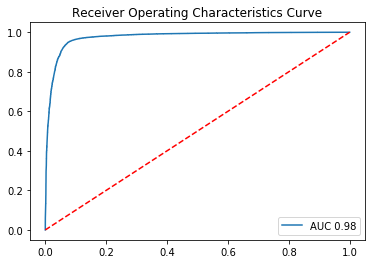

In [66]:
plt.plot(fpr, tpr, label='AUC %0.2f'%(roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.title("Receiver Operating Characteristics Curve")
plt.show()

In [68]:
from sklearn.metrics import classification_report
import csv
import pandas as pd
print(classification_report(test_label, list(map(lambda x: round(x), test_pred))))

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     10631
         1.0       0.97      0.95      0.96     23369

   micro avg       0.94      0.94      0.94     34000
   macro avg       0.93      0.94      0.93     34000
weighted avg       0.94      0.94      0.94     34000

